In [4]:
import mysql.connector
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Conexión a la base de datos
def connect_to_db():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="sistemas",
        database="MarketBasketDB"
    )

# Extraer transacciones de la base de datos
def fetch_transactions():
    db = connect_to_db()
    cursor = db.cursor()
    cursor.execute("""
        SELECT TransactionID, ItemID 
        FROM TransactionItems
        ORDER BY TransactionID
    """)
    transactions = {}
    for transaction_id, item_id in cursor.fetchall():
        if transaction_id not in transactions:
            transactions[transaction_id] = []
        transactions[transaction_id].append(item_id)
    db.close()
    return list(transactions.values())


Pregunta 6

In [5]:
def frequent_itemsets(transactions, k):
    itemsets = Counter()
    for transaction in transactions:
        items = set(transaction)
        for subset in combinations(items, 2):  # Cambia el valor 2 para buscar conjuntos de tamaño diferente
            itemsets[subset] += 1
    return [itemset for itemset, count in itemsets.items() if count >= k]

# Ejemplo de uso
transactions = fetch_transactions()
k = 3
print("Frequent Itemsets:", frequent_itemsets(transactions, k))


Frequent Itemsets: [(2, 3), (4, 5), (4, 6), (5, 6), (1, 10), (1, 9), (3, 4), (3, 5), (2, 4), (1, 6), (8, 9), (1, 7), (8, 5), (2, 5), (9, 7), (9, 6), (10, 3), (2, 7), (8, 1), (8, 10), (2, 6), (3, 7), (8, 4)]


Pregunta 7

Edges in Co-occurrence Graph: [(1, 2), (1, 3), (1, 10), (1, 9), (1, 5), (1, 6), (1, 4), (1, 7), (1, 8), (2, 3), (2, 4), (2, 8), (2, 5), (2, 7), (2, 6), (3, 4), (3, 5), (3, 8), (3, 10), (3, 7), (4, 5), (4, 6), (4, 7), (4, 10), (4, 8), (5, 6), (5, 8), (5, 7), (5, 10), (6, 10), (6, 8), (6, 9), (8, 7), (8, 9), (8, 10), (7, 9), (7, 10)]


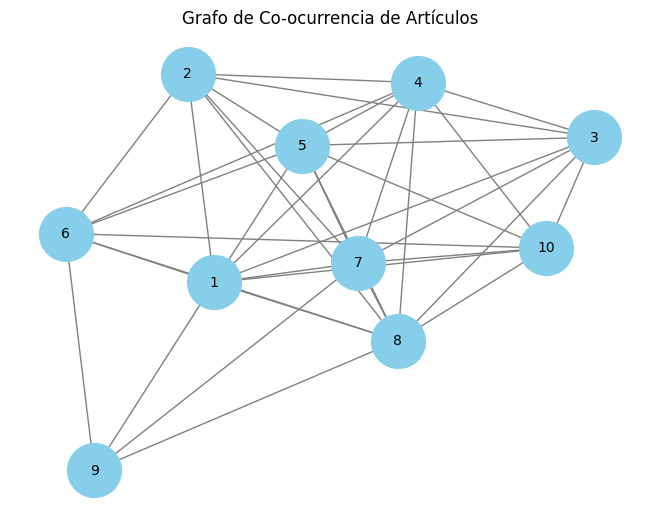

In [ ]:
def build_cooccurrence_graph(transactions, k):
    itemsets = Counter()
    for transaction in transactions:
        items = set(transaction)
        for subset in combinations(items, 2):
            itemsets[subset] += 1
    G = nx.Graph()
    for itemset, count in itemsets.items():
        if count >= k:
            G.add_edge(*itemset)
    return G

# Generar y mostrar el grafo
graph = build_cooccurrence_graph(transactions, k=2)
print("Edges in Co-occurrence Graph:", graph.edges())

# Visualizar el grafo
nx.draw(graph, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1500, font_size=10)
plt.title("Grafo de Co-ocurrencia de Artículos")
plt.show()


Pregunta 8

In [7]:
def find_communities(graph):
    return list(nx.connected_components(graph))

# Encontrar y mostrar comunidades
communities = find_communities(graph)
print("Communities:", communities)


Communities: [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}]
